In [1]:
# Отдельная генерация и сохранение train/text массивов для xgbooster  (2017-07-02)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, estimateResult

In [6]:
binsData = 96

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trWork, teWork = '../Work/Train', '../Work/Test'
print (trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [7]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [9]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [10]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [11]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [12]:
def generateArrays( dirIn, nameAsk, binsData, debugOK=False) :
    #nameAsk = os.listdir(dirIn); print(len(nameAsk))
    trOX, trOY, i, size = [], [], 0, len(nameAsk)
    if debugOK : size = 3
    print(datetime.datetime.now(),len(nameAsk),size)
    for nn in nameAsk[0:size] :
        nf = os.path.join(dirIn,nn);
        nx = formImHist(nf,binsData,printOK=debugOK)
        ##nx = formImHist(nf,binsData,printOK=debugOK,EqualizeOK=True,GaussianOK=True)
        if (i==0) : trOX = np.zeros((size,nx.shape[0]),dtype=np.uint16) ## расчет на максимальный массив 256x256=65536=np.uint16
        if (nx is not None) :
            trOX[i] = nx
            trOY.append(nn)
        i += 1
        if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
            
    ##trOX = np.array(trOX);
    trOY = np.array([os.path.splitext(x)[0] for x in trOY]);

    print(datetime.datetime.now())
    return (trOX, trOY)

def generateTest ( dirIn, binsData, debugOK=False) :
    nameAsk = os.listdir(dirIn); #print(len(nameAsk))
    return(generateArrays(dirIn,nameAsk,binsData,debugOK=debugOK))

def generateTrain( dirIn, binsData, nameList, debugOK=False) :
    ##nameAsk = os.listdir(dirIn); #print(len(nameAsk))
    return(generateArrays(dirIn,nameList,binsData,debugOK=debugOK))


In [51]:
# Генерация для JPG
#binsList = [256,96,128] 
#binsList = [32,64,80]
ttExt    = '.jpg'
debug = False
tDirs = (trDirJPG,teDirJPG)

In [14]:
# Генерация для TIF
binsList = [64,128,256]
#binsList = [256,96,128] 
#binsList = [32,64,80]
ttExt    = '.tif'
debug = False
tDirs = (trDirTIF,teDirTIF)

In [53]:
binsList = [128,256]
debug = False

In [54]:
dirIn    = tDirs[0]
trOY = labelList;
for bds in binsList :
    print ('-------->: bins={} Ext={} input-dir={}'.format(bds,ttExt,dirIn))
    nameListExt = [x+ttExt for x in nameList]
    trOX, _     = generateTrain(dirIn,bds,nameListExt,debugOK=debug)
    np.save('../Data-XGB/Datas/train-'+str(10000+bds)+ttExt+'-XX.npy',trOX)
    np.save('../Data-XGB/Datas/train-'+str(10000+bds)+ttExt+'-YY.npy',trOY)
    #print (bds,trOX.shape,trOY.shape, (trOX.shape[1]/bds)*bds, trOX.shape[1]/3)dirIn    = teDirJPG

-------->: bins=128 Ext=.jpg input-dir=../Data/train-jpg
2017-07-08 16:53:52.871990 40479 40479
2017-07-08 16:55:29.214502 	 5000 	 train_4999.jpg
2017-07-08 16:57:02.966772 	 10000 	 train_9999.jpg
2017-07-08 16:58:33.759720 	 15000 	 train_14999.jpg
2017-07-08 17:00:01.230119 	 20000 	 train_19999.jpg
2017-07-08 17:01:26.478080 	 25000 	 train_24999.jpg
2017-07-08 17:02:45.166772 	 30000 	 train_29999.jpg
2017-07-08 17:04:01.409781 	 35000 	 train_34999.jpg
2017-07-08 17:05:13.979974 	 40000 	 train_39999.jpg
2017-07-08 17:05:21.050645
-------->: bins=256 Ext=.jpg input-dir=../Data/train-jpg
2017-07-08 17:05:21.207303 40479 40479
2017-07-08 17:05:55.704306 	 5000 	 train_4999.jpg
2017-07-08 17:06:29.863514 	 10000 	 train_9999.jpg
2017-07-08 17:07:03.889412 	 15000 	 train_14999.jpg
2017-07-08 17:07:37.505170 	 20000 	 train_19999.jpg
2017-07-08 17:08:10.630859 	 25000 	 train_24999.jpg
2017-07-08 17:08:45.071463 	 30000 	 train_29999.jpg
2017-07-08 17:09:19.647541 	 35000 	 train_34

In [55]:
dirIn    = tDirs[1]
for bds in binsList :
    print ('-------->: bins={} Ext={} input-dir={}'.format(bds,ttExt,dirIn))
    trOX, trOY = generateTest(dirIn,bds,debugOK=debug)
    np.save('../Data-XGB/Datas/test-'+str(10000+bds)+ttExt+'-XX.npy',trOX)
    np.save('../Data-XGB/Datas/test-'+str(10000+bds)+ttExt+'-YY.npy',trOY)
    #print (bds,trOX.shape,trOY.shape, (trOX.shape[1]/bds)*bds, trOX.shape[1]/3)

-------->: bins=128 Ext=.jpg input-dir=../Data/test-jpg-v2
2017-07-08 17:09:57.394177 61191 61191
2017-07-08 17:10:32.573748 	 5000 	 test_14523.jpg
2017-07-08 17:11:07.032323 	 10000 	 test_19029.jpg
2017-07-08 17:11:39.950659 	 15000 	 test_23524.jpg
2017-07-08 17:12:13.175858 	 20000 	 test_28015.jpg
2017-07-08 17:12:46.868780 	 25000 	 test_32520.jpg
2017-07-08 17:13:20.093157 	 30000 	 test_37026.jpg
2017-07-08 17:13:52.768331 	 35000 	 test_4908.jpg
2017-07-08 17:14:25.633735 	 40000 	 test_9402.jpg
2017-07-08 17:14:58.145944 	 45000 	 file_13913.jpg
2017-07-08 17:15:31.650706 	 50000 	 file_18419.jpg
2017-07-08 17:16:16.052760 	 55000 	 file_4564.jpg
2017-07-08 17:16:53.972847 	 60000 	 file_892.jpg
2017-07-08 17:17:02.462207
-------->: bins=256 Ext=.jpg input-dir=../Data/test-jpg-v2
2017-07-08 17:17:02.674398 61191 61191
2017-07-08 17:17:36.695654 	 5000 	 test_14523.jpg
2017-07-08 17:18:09.036967 	 10000 	 test_19029.jpg
2017-07-08 17:18:43.200945 	 15000 	 test_23524.jpg
2017

65535 0 255.961650134
[58861 36757 54014 ...,  6523 30377 38568] 0 255.961650134


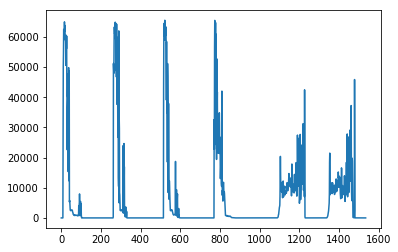

In [50]:
print (trOX.max(), trOX.min(), trOX.mean())
print (trOX.max(axis=1), trOX.min(), trOX[:].mean())

plt.plot(trOX[0:10000].max(axis=0)); plt.show()

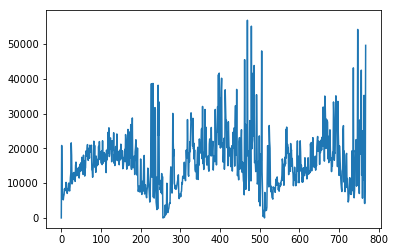

In [57]:
plt.plot(trOX[0:10000].max(axis=0)); plt.show()

In [25]:
ax  = trOX
ax2 = np.zeros((ax.shape[0],(ax.shape[1]/2)))
for i in range(ax2.shape[1]) :
    ax2[:,i] = ax[:,2*i]+ax[:,2*i+1]
trOX.shape, ax2.shape

((61191, 384), (61191, 192))

In [153]:
##--------------------- Examples save/load procedure

In [154]:
if False :
    trX = np.load('../Work/train-data-XX'+str(binsData)+ttExt+'.npy')
    trY = np.load('../Work/train-data-YY'+str(binsData)+ttExt+'.npy')
    print(trX.shape,trY.shape)

In [155]:
if False :
    np.save('../Work/test-data-XX'+str(binsData)+ttExt+'.npy',trOX)
    np.save('../Work/test-data-YY'+str(binsData)+ttExt+'.npy',trOY)